In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Dataset RWI-GEO-RED Panel Campus File

The Panel Campus File covers the 15 biggest cities in Germany. These cities are Berlin, Hamburg,
Munich, Cologne, Frankfurt, Stuttgart, Düsseldorf, Leipzig, Dortmund, Essen, Bremen, Dresden,
Hannover, Nuremberg and Duisburg.

## Load Data

In [2]:
raw_df <- read.csv('./data/RWI-GEO-RED/panel-15-largest-cities-germany/CampusFile_WK_cities.csv')

In [3]:
df = raw_df
nrow(df)

[1] 828135

In [ ]:
df %>%
    summarise(
        min_adat = min(as.Date(paste0(adat, "-01")), na.rm = TRUE),
        max_ada t = max(as.Date(paste0(adat, "-01")), na.rm = TRUE)
    )

min_adat,max_adat
<date>,<date>
2007-01-01,2024-12-01


In [29]:
df %>%
    filter(!is.na(plz)) %>%
    count(plz, name = "entries") %>%
    arrange(desc(entries))

plz,entries
<fct>,<int>
10245,6407
10115,5936
10247,5346
50858,4466
60486,4369
60598,4017
60438,3807
50735,3727
60599,3622


## Berlin subset

In [4]:
extract_berlin_samples <- function(source_df) {
    df_berlin <- subset(source_df, !is.na(plz) &
        as.integer(as.character(plz)) >= 10115 &
        as.integer(as.character(plz)) <= 14199)
    return (
        df_berlin
    )
}


Features:

    - adat: start of ad 

    - edat: end of ad

    - etage: what level the home is on (keep metric for now - if relationship linear - keep)

    - anzahletagen: how many levels in the home (keep metric for now - if relationship linear - keep)

## Feature Cleanup

### Utils

In [5]:
sentinels <- c(-9, -8, -7, -6, -5)
replace_sentinels <- function(x, s = sentinels) {
  x[x %in% s] <- NA
  return (
    x
  )
}


### Cleanup sentinels

In [6]:
colnames(df)

[1] "obid"                   "plz"                    "kaufpreis"             
 [4] "heizkosten"             "baujahr"                "letzte_modernisierung" 
 [7] "wohnflaeche"            "grundstuecksflaeche"    "nutzflaeche"           
[10] "etage"                  "anzahletagen"           "zimmeranzahl"          
[13] "nebenraeume"            "schlafzimmer"           "badezimmer"            
[16] "parkplatzpreis"         "wohngeld"               "ev_kennwert"           
[19] "laufzeittage"           "immobilientyp"          "aufzug"                
[22] "balkon"                 "denkmalobjekt"          "einbaukueche"          
[25] "einliegerwohnung"       "ev_wwenthalten"         "gaestewc"              
[28] "garten"                 "keller"                 "parkplatz"             
[31] "rollstuhlgerecht"       "bauphase"               "ausstattung"           
[34] "energieeffizienzklasse" "energieausweistyp"      "haustier_erlaubt"      
[37] "heizungsart"            "kategorie_Wohnung"      "objektzustand"         
[40] "ergg_1km"               "blid"                   "gid2019"               
[43] "kid2019"                "bef1"                   "bef2"                  
[46] "bef10"                  "bef9"                   "bef8"                  
[49] "bef7"                   "bef6"                   "bef5"                  
[52] "bef4"                   "bef3"                   "anbieter"              
[55] "spell"                  "dataset_version"        "adat"                  
[58] "edat"                   "price_sqm"

In [7]:
cols_to_clean <- c(
    "aufzug", "plz", "heizkosten",
    "balkon", "letzte_modernisierung", "grundstuecksflaeche",
    "nutzflaeche", "anzahletagen", "zimmeranzahl",
    "nebenraeume", "schlafzimmer", "badezimmer", "parkplatzpreis",
    "wohngeld", "denkmalobjekt", "einbaukueche", "einliegerwohnung",
    "garten", "keller", "parkplatz", "rollstuhlgerecht", "bauphase",
    "haustier_erlaubt", "anbieter", "gaestewc",
    "bef1", "bef2", "bef3", "bef4", "bef5","bef6", "bef7", "bef8", "bef9", "bef10",
    "kategorie_Wohnung", "objektzustand", "ausstattung", "energieausweistyp",
    # etage can be here the min of etage is -1
    "etage",
    "ev_kennwert", "ev_wwenthalten",
    "energieeffizienzklasse",
    "heizungsart"
)

In [8]:
df[cols_to_clean] <- lapply(df[cols_to_clean], replace_sentinels)

In [9]:
factor_cols <- c(
    "plz",
    "immobilientyp",
    "parkplatz",
    "balkon",
    "denkmalobjekt",
    "einbaukueche",
    "gaestewc",
    "garten",
    "keller",
    "rollstuhlgerecht",
    "ausstattung",
    "energieausweistyp",
    "kategorie_Wohnung",
    "dataset_version"
)

In [10]:
df[factor_cols] <- lapply((df[factor_cols]), as.factor)

#### obid

In [11]:
df$obid <- as.character(df$obid)

#### adat edat

In [12]:
df$adat <- as.Date(paste0(df$adat, "-01"))  # 01 for the day (adata only is YYYY-MM)
df$edat <- as.Date(paste0(df$edat, "-02")) # 01 for the day (edat only YYYY-MM treat as month only)

In [13]:
summary(df)

     obid                plz           kaufpreis         heizkosten    
 Length:828135      10245  :  6407   Min.   :  18800   Min.   :  0.00  
 Class :character   10115  :  5936   1st Qu.: 120000   1st Qu.: 40.00  
 Mode  :character   10247  :  5346   Median : 227000   Median : 60.00  
                    50858  :  4466   Mean   : 290077   Mean   : 74.19  
                    60486  :  4369   3rd Qu.: 389000   3rd Qu.: 94.50  
                    (Other):801154   Max.   :1699000   Max.   :300.00  
                    NA's   :   457                     NA's   :827988  
    baujahr     letzte_modernisierung  wohnflaeche     grundstuecksflaeche
 Min.   :1500   Min.   :1890          Min.   : 24.01   Min.   : NA        
 1st Qu.:1950   1st Qu.:2005          1st Qu.: 59.65   1st Qu.: NA        
 Median :1972   Median :2010          Median : 77.00   Median : NA        
 Mean   :1968   Mean   :2008          Mean   : 83.34   Mean   :NaN        
 3rd Qu.:2000   3rd Qu.:2014          3rd Qu.:100

## Cleanup unneded columns and validate data

In [14]:
cols_to_drop = c(
    "grundstuecksflaeche", # all values are NA
    "einliegerwohnung", # all values are NA,
    "bef6", # only has about 10 rows with values
    "bef7","bef8","bef9","bef10", # no values in these columns,
    "haustier_erlaubt", # no values here
    "bauphase" # no values for wohnungen
)

In [15]:
df <- df %>% select(-cols_to_drop)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(cols_to_drop)

  # Now:
  data %>% select(all_of(cols_to_drop))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [17]:
nrow(df)

[1] 828135

# Exploration (Only Berlin)

In [15]:
dfb = extract_berlin_samples(df)

In [16]:
nrow(dfb)

[1] 180409

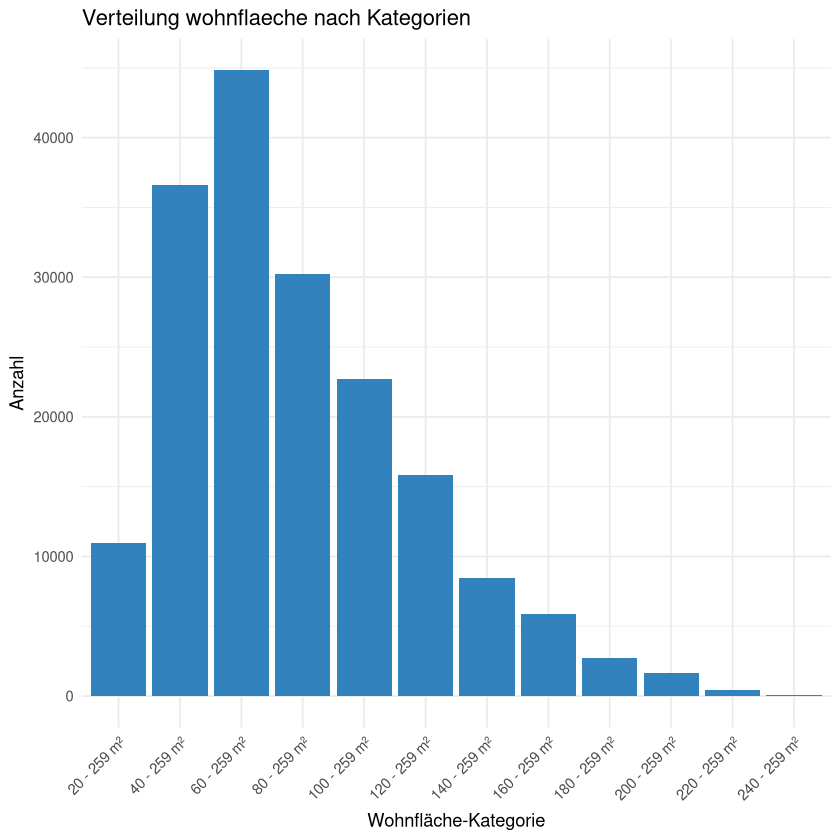

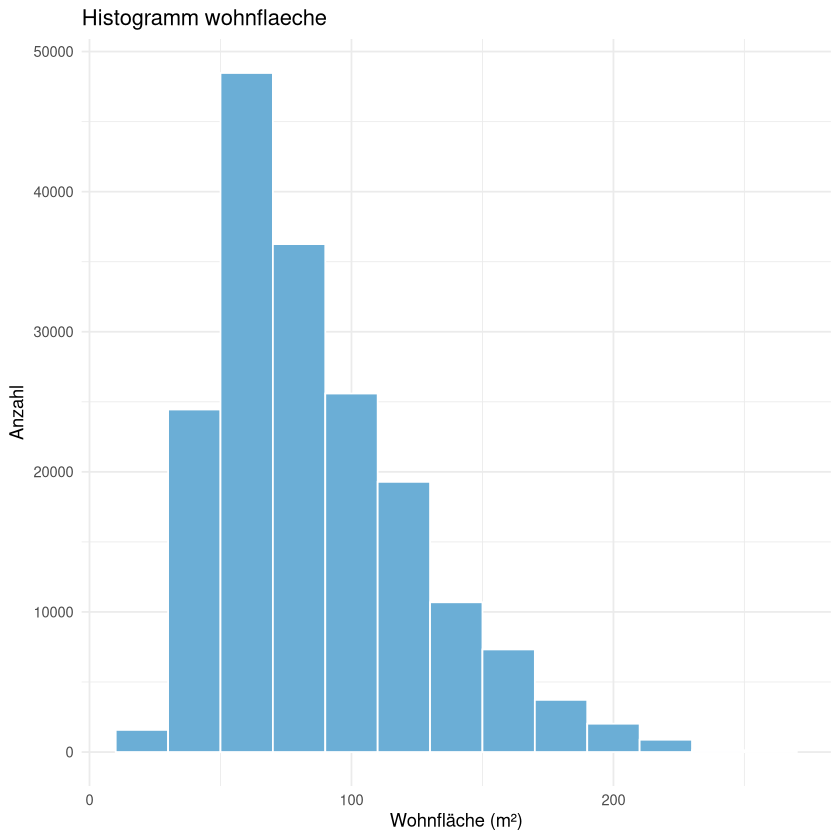

In [34]:
# Categorize and plot wohnfläche (fallbacks to wohnflaeche / nutzflaeche)
if (!exists("size_var")) {
    size_var <- dplyr::case_when(
        "wohnflaeche" %in% names(dfb) ~ "wohnflaeche",
        "wohnfläche" %in% names(dfb) ~ "wohnfläche",
        TRUE ~ "nutzflaeche"
    )
}

# Build 20 m² wide bins from 0 up to max
max_area <- max(dfb[[size_var]], na.rm = TRUE)
breaks <- seq(0, ceiling(max_area / 20) * 20, by = 20)
if (length(breaks) < 2) breaks <- c(0, 50)  # safety

dfb_area_bins <- dfb %>%
    filter(!is.na(.data[[size_var]]), .data[[size_var]] > 0) %>%
    mutate(area_bin = cut(.data[[size_var]],
                                                breaks = breaks,
                                                include.lowest = TRUE,
                                                right = FALSE,
                                                labels = paste(head(breaks, -1), "-", tail(breaks, 1) - 1, "m²"))) %>%
    count(area_bin)

# Bar plot of counts per category
p_bins <- ggplot(dfb_area_bins, aes(x = area_bin, y = n)) +
    geom_col(fill = "#3182BD") +
    labs(title = paste("Verteilung", size_var, "nach Kategorien"),
             x = "Wohnfläche-Kategorie",
             y = "Anzahl") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Histogram of raw values
p_hist <- dfb %>%
    filter(!is.na(.data[[size_var]]), .data[[size_var]] > 0) %>%
    ggplot(aes(.data[[size_var]])) +
    geom_histogram(binwidth = 20, fill = "#6BAED6", color = "white") +
    labs(title = paste("Histogramm", size_var),
             x = "Wohnfläche (m²)",
             y = "Anzahl") +
    theme_minimal()

p_bins
p_hist

Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


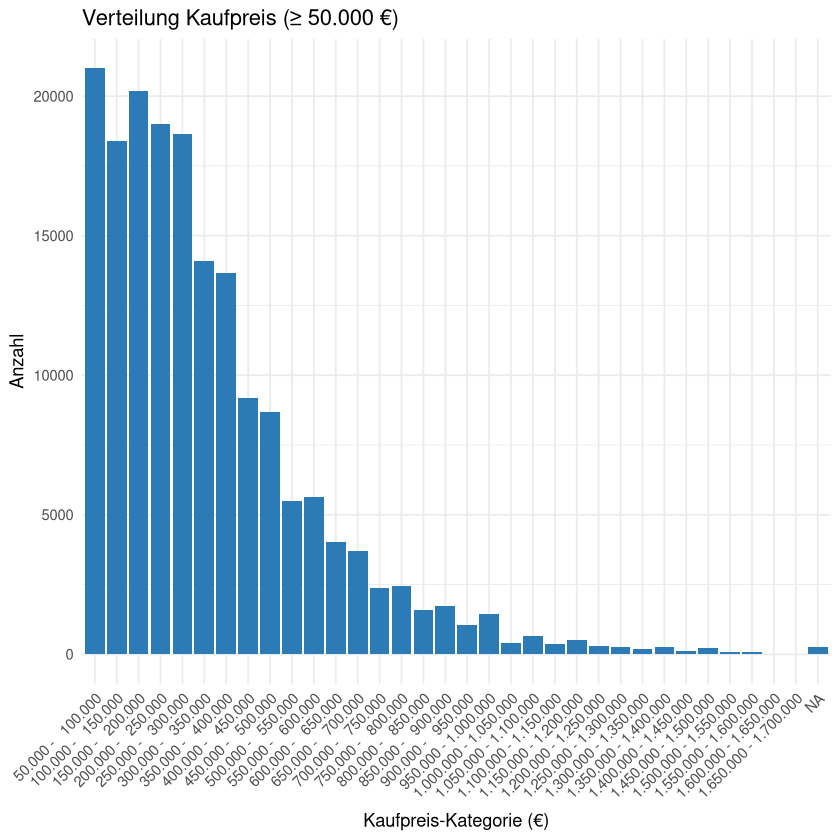

In [32]:
# Bin kaufpreis into 50k-wide categories starting at 50,000 and plot counts
max_price <- max(dfb$kaufpreis, na.rm = TRUE)

# Sequence of breakpoints (50,000, 100,000, ... up to/max_price rounded up to next 50k)
breaks <- seq(50000, ceiling(max_price / 50000) * 50000, by = 50000)
if (length(breaks) < 2) breaks <- c(50000, 100000)  # safety if very small range

# Build labels like 50.000 - 100.000 etc.
labels <- paste(
    format(head(breaks, -1), big.mark = ".", scientific = FALSE),
    "-",
    format(tail(breaks, -1), big.mark = ".", scientific = FALSE)
)

dfb_kauf_bins <- dfb %>%
    filter(!is.na(kaufpreis), kaufpreis >= 50000) %>%
    mutate(kaufpreis_cat = cut(kaufpreis, breaks = breaks, labels = labels, right = TRUE, include.lowest = FALSE)) %>%
    count(kaufpreis_cat)

ggplot(dfb_kauf_bins, aes(x = kaufpreis_cat, y = n)) +
    geom_col(fill = "#2C7BB6") +
    labs(
        title = "Verteilung Kaufpreis (≥ 50.000 €)",
        x = "Kaufpreis-Kategorie (€)",
        y = "Anzahl"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Dataset overview

Warning message:
“Removed 2527764 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


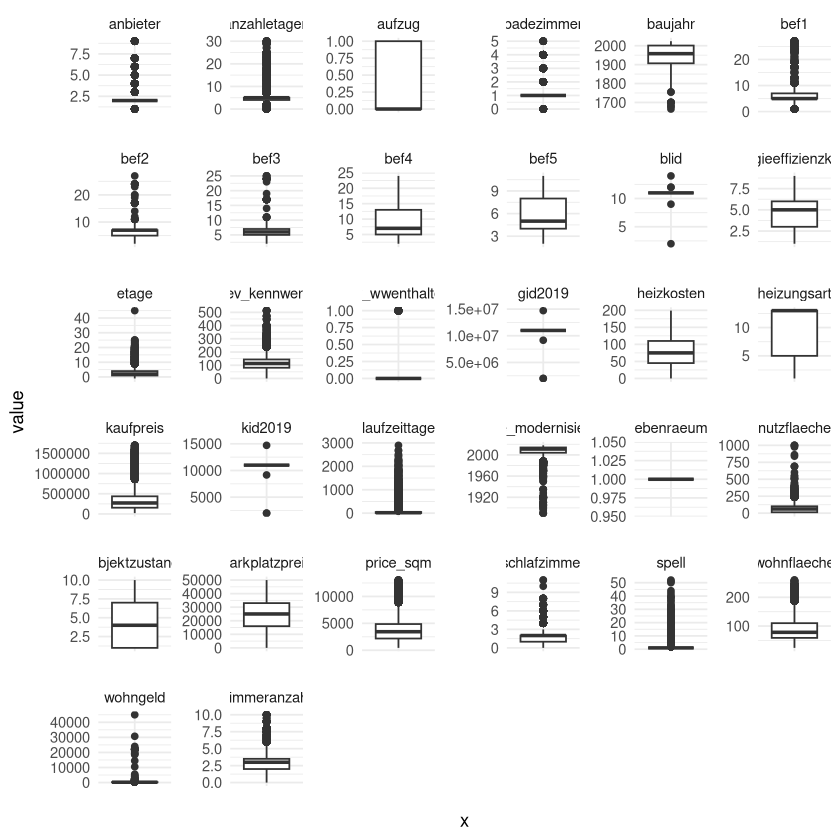

In [18]:
ggplot(dfb %>% select(where(is.numeric)) %>% pivot_longer(everything()),
       aes(x = "", y = value)) +
  geom_boxplot() +
  facet_wrap(~name, scales = "free") +
  theme_minimal()

## Correlations

In [19]:
library(corrplot)

corrplot 0.95 loaded



Warning message in cor(dfb_numeric, use = "pairwise.complete.obs"):
“the standard deviation is zero”


ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 110, 108


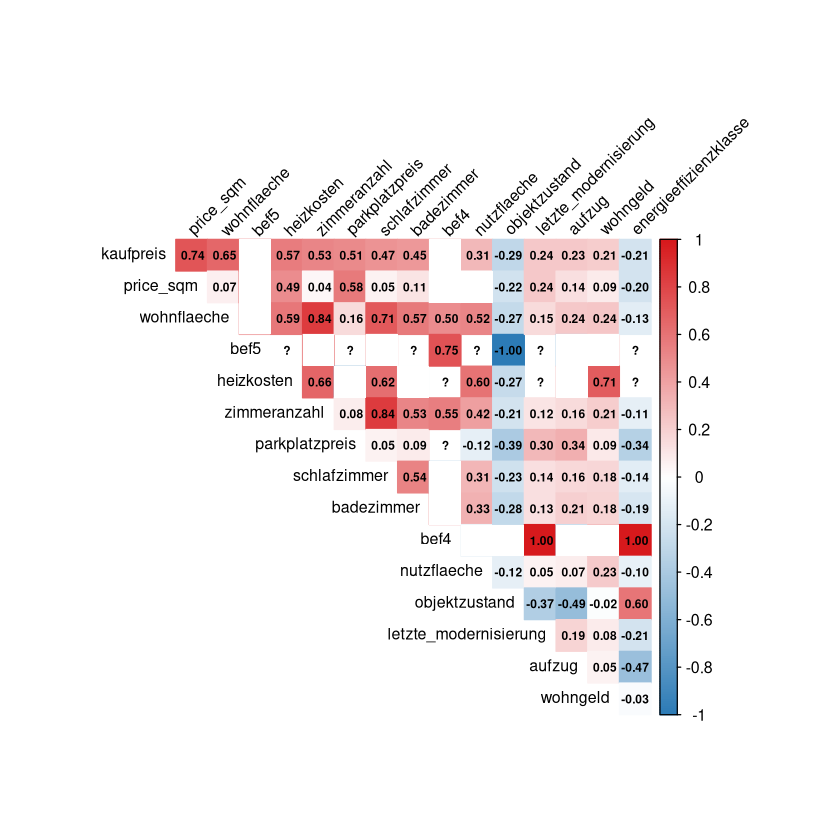

In [31]:
# prettier, target-focused correlation plot (top correlated features with kaufpreis)
dfb_numeric <- dfb %>% select(where(is.numeric))

# full correlation matrix
cm <- cor(dfb_numeric, use = "pairwise.complete.obs")

# pick top N by |r| with target
target <- "kaufpreis"
top_n <- 15
target_corr <- cm[target, setdiff(colnames(cm), target)]
target_corr <- target_corr[order(abs(target_corr), decreasing = TRUE)]
top_vars <- names(target_corr)[seq_len(min(top_n, length(target_corr)))]
sub_vars <- c(target, top_vars)
cm_sub <- cm[sub_vars, sub_vars]

# p-value matrix for significance masking
cor_pmat <- function(vars, data) {
    n <- length(vars)
    p <- matrix(NA_real_, n, n, dimnames = list(vars, vars))
    for (i in seq_len(n)) {
        for (j in i:n) {
            x <- data[[vars[i]]]; y <- data[[vars[j]]]
            idx <- stats::complete.cases(x, y)
            pval <- if (sum(idx) > 2) suppressWarnings(stats::cor.test(x[idx], y[idx])$p.value) else NA_real_
            p[i, j] <- pval; p[j, i] <- pval
        }
    }
    p
}
pmat_sub <- cor_pmat(sub_vars, dfb_numeric)

# nice palette and plot
pal <- colorRampPalette(c("#2C7BB6", "#FFFFFF", "#D7191C"))(200)
par(bg = "white", mar = c(0, 0, 3, 0))
corrplot(
    cm_sub,
    method = "color",
    type = "upper",        # shows the kaufpreis row clearly (it's first)
    order = "original",    # keep kaufpreis first, others by |r|
    col = pal,
    tl.col = "black",
    tl.srt = 45,
    tl.cex = 0.8,
    addCoef.col = "black",
    number.cex = 0.6,
    cl.cex = 0.8,
    diag = FALSE,
    p.mat = pmat_sub,
    sig.level = 0.05,
    insig = "blank"        # hide insignificant cells
)
mtext("Correlations with Kaufpreis (top |r|)", side = 3, line = 1, cex = 1)

## Kaufpreis (Y)

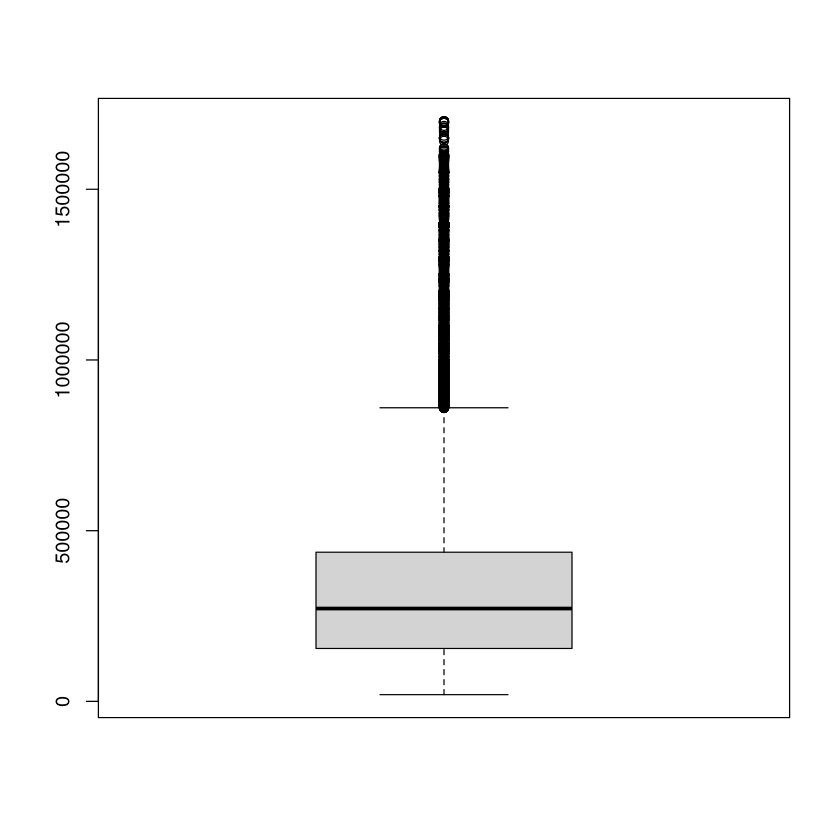

In [21]:
par(bg="white")
boxplot(dfb$kaufpreis)

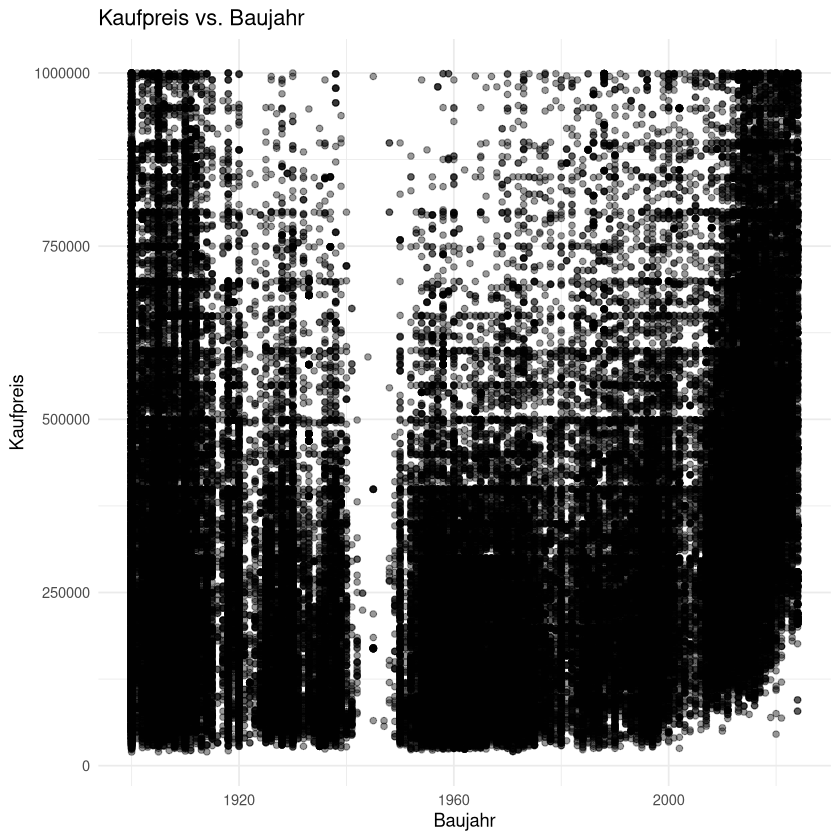

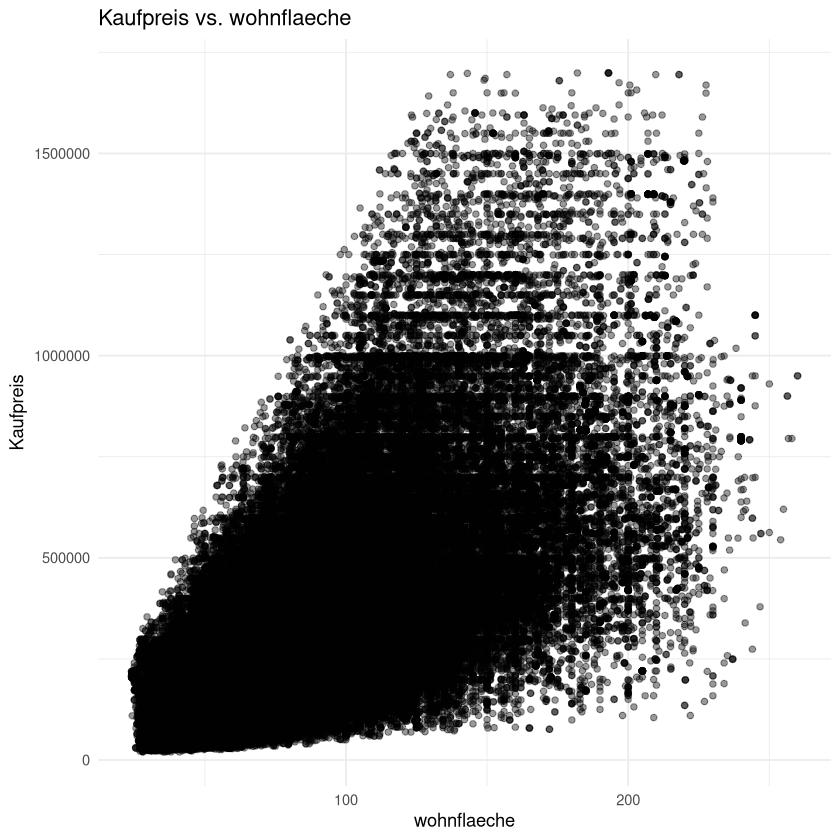

In [22]:
# Scatterplots Kaufpreis vs Baujahr und Kaufpreis vs Wohn-/Nutzflaeche
size_var <- dplyr::case_when(
    "wohnflaeche" %in% names(dfb) ~ "wohnflaeche",
    "wohnfläche" %in% names(dfb) ~ "wohnfläche",
    TRUE ~ "nutzflaeche"
)

p_baujahr <- dfb %>%
    filter(!is.na(kaufpreis), !is.na(baujahr), baujahr >= 1900, kaufpreis <=1000000) %>%
    ggplot(aes(baujahr, kaufpreis)) +
    geom_point(alpha = 0.4) +
    theme_minimal() +
    labs(title = "Kaufpreis vs. Baujahr", x = "Baujahr", y = "Kaufpreis")

p_flaeche <- dfb %>%
    filter(!is.na(kaufpreis), !is.na(.data[[size_var]])) %>%
    ggplot(aes(.data[[size_var]], kaufpreis)) +
    geom_point(alpha = 0.4) +
    theme_minimal() +
    labs(title = paste("Kaufpreis vs.", size_var), x = size_var, y = "Kaufpreis")

p_baujahr
p_flaeche
